<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
%cd /content/drive/MyDrive/CS490/CS490-Senior-Research-Project

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [3]:
! git pull

Already up to date.


In [15]:
!git config --global user.email "arnisa.fazla@ug.bilkent.edu.tr"
!git config --global user.name "arnisafazla"

In [16]:
! git commit -m 'debug Base_WGAN.py'

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
	modified:   CS_490_main.ipynb
	modified:   dataset.py
	modified:   models/Base_WGAN.py
	modified:   models/critic_models/LSTM_critic.py
	modified:   models/generator_models/LSTM_generator.py
	modified:   models/generator_models/__pycache__/LSTM_generator.cpython-37.pyc
	modified:   setup.ipynb
	modified:   tools.py

Untracked files:
	__pycache__/
	model.png
	models/__pycache__/
	models/critic_models/__pycache__/

no changes added to commit


In [13]:
! git add models/
! git add tools.py

In [15]:
! git push origin main

Counting objects: 12, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (11/11), done.
Writing objects: 100% (12/12), 8.52 KiB | 671.00 KiB/s, done.
Total 12 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/arnisafazla/CS490-Senior-Research-Project.git
   0b56f57..3398b38  main -> main


In [12]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# path to the cloned repo
main_dir = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project'  
# path to the dataset folder
dataset_dir = '/content/drive/MyDrive/CS490/dataset'
%cd {main_dir}
sys.path.insert(0,main_dir)
from models.dataset import Dataset
from models.critic_models.LSTM_critic import define_critic
from models.generator_models.LSTM_generator import define_generator
from models.Base_WGAN import Base_WGAN, GANMonitor

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


ModuleNotFoundError: ignored

In [5]:
%cd ..
!mkdir generator_models
%cd generator_models
! touch LSTM_generator.py

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/models
/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/models/generator_models


In [ ]:
dataset = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path='/content/drive/MyDrive/CS490/dataset', step_size=10, frames=400)

anger


100%|██████████| 65/65 [00:10<00:00,  6.08it/s]


joy


100%|██████████| 29/29 [00:05<00:00,  5.68it/s]


fear


100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


neutral


100%|██████████| 84/84 [00:11<00:00,  7.25it/s]


sadness


100%|██████████| 46/46 [00:07<00:00,  6.11it/s]


pride


100%|██████████| 24/24 [00:04<00:00,  5.37it/s]


In [ ]:
dist = Dataset.classes_dist(dataset)

<function matplotlib.pyplot.figure>

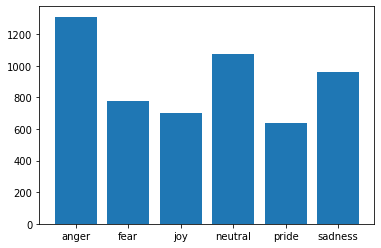

In [ ]:
Dataset.viz_dist(dataset)

In [ ]:
Dataset.balance(dataset)

No. of samples in each class will be:  640


In [13]:
# save this as a separate file
config = {       # change hyperparams here
        'latent_dim' : 400,
        'in_shape' : (400, 69),
        'n_classes' : 6,
        'init_std' : 0.01,
        'critic_opt' : 'Adam', # RMS or Adam
        'critic_lr' : 0.005,
        'gen_opt' : 'Adam',
        'gen_lr' : 0.005,
        'wrong_labels' : True,    # feed in real data with wron labels as well
        'epochs' : 20,
        'n_batch' : 128,
        'n_critic' : 5,
        'dataset_balanced' : True,
        'critic_batch_norm' : True,
        'critic_dropout' : 0,
        'gp_weight' : 10.0      # for the gradient penalty used in critic
      }

In [ ]:
critic = define_critic(config)
plot_model(critic, show_shapes=True, show_layer_names=True)
generator = define_generator(config)
plot_model(generator, show_shapes=True, show_layer_names=True)

In [ ]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real, fake):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss
# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

# Set the number of epochs for trainining.
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=1, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

In [11]:
a = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/models/generator_models'
os.path.basename(a)

'generator_models'